In [69]:
import numpy as np

# Assuming you have already read the raster layers into variables (slope_layer, lulc_layer, drainage_layer, soil_layer, roads_layer)

# List of layer names
layer_names = ['Slope', 'Land Use/Land Cover', 'Drainage', 'Soil', 'Roads']

# Function to get user input for pairwise comparisons
def get_pairwise_comparisons(layer_names):
    n_layers = len(layer_names)
    pairwise_matrix = np.ones((n_layers, n_layers))

    print("Please provide pairwise comparisons for the importance of each layer relative to another.")
    print("Use a scale from 1 (equal importance) to 9 (extremely more important).")

    for i in range(n_layers):
        for j in range(i + 1, n_layers):
            weight = float(input(f"How important is '{layer_names[i]}' compared to '{layer_names[j]}'? Enter a value from 1 to 9: "))
            pairwise_matrix[i, j] = weight
            pairwise_matrix[j, i] = 1 / weight

    return pairwise_matrix

# Get pairwise comparisons from the user
pairwise_comparison_matrix = get_pairwise_comparisons(layer_names)

# Display the pairwise comparison matrix
print("\nPairwise Comparison Matrix:")
print(pairwise_comparison_matrix)

Please provide pairwise comparisons for the importance of each layer relative to another.
Use a scale from 1 (equal importance) to 9 (extremely more important).
How important is 'Slope' compared to 'Land Use/Land Cover'? Enter a value from 1 to 9: 1
How important is 'Slope' compared to 'Drainage'? Enter a value from 1 to 9: 3
How important is 'Slope' compared to 'Soil'? Enter a value from 1 to 9: 4
How important is 'Slope' compared to 'Roads'? Enter a value from 1 to 9: 6
How important is 'Land Use/Land Cover' compared to 'Drainage'? Enter a value from 1 to 9: 4
How important is 'Land Use/Land Cover' compared to 'Soil'? Enter a value from 1 to 9: 4
How important is 'Land Use/Land Cover' compared to 'Roads'? Enter a value from 1 to 9: 6
How important is 'Drainage' compared to 'Soil'? Enter a value from 1 to 9: 6
How important is 'Drainage' compared to 'Roads'? Enter a value from 1 to 9: 4
How important is 'Soil' compared to 'Roads'? Enter a value from 1 to 9: 4

Pairwise Comparison Matr

In [70]:
# Function to normalize the pairwise comparison matrix
def normalize_pairwise_matrix(pairwise_matrix):
    n_layers = pairwise_matrix.shape[0]

    # Normalize each row by dividing by the geometric mean of the row
    for i in range(n_layers):
        geometric_mean = np.power(np.prod(pairwise_matrix[i, :]), 1/n_layers)
        pairwise_matrix[i, :] /= geometric_mean

    return pairwise_matrix

# Normalize the pairwise comparison matrix
normalized_pairwise_matrix = normalize_pairwise_matrix(pairwise_comparison_matrix)

# Display the normalized pairwise comparison matrix
print("\nNormalized Pairwise Comparison Matrix:")
print(normalized_pairwise_matrix)


Normalized Pairwise Comparison Matrix:
[[0.4251415  0.4251415  1.2754245  1.700566   2.550849  ]
 [0.40137078 0.40137078 1.60548312 1.60548312 2.40822469]
 [0.29018352 0.21763764 0.87055056 5.22330338 3.48220225]
 [0.47204376 0.47204376 0.31469584 1.88817502 7.55270009]
 [0.59420082 0.59420082 0.89130123 0.89130123 3.56520492]]


In [71]:
# Function to calculate the weights using the eigenvalue method
def calculate_weights(pairwise_matrix):
    n_layers = len(pairwise_matrix)

    # Calculate the normalized matrix
    normalized_matrix = pairwise_matrix / pairwise_matrix.sum(axis=0)

    # Calculate the eigenvector
    _, eigenvector = np.linalg.eig(normalized_matrix)

    # Normalize the eigenvector to get the weights
    weights = eigenvector[:, 0] / eigenvector[:, 0].sum()

    return weights

# Calculate weights
weights = calculate_weights(pairwise_comparison_matrix)

# Display the calculated weights
print("\nCalculated Weights:")
for layer, weight in zip(layer_names, weights):
    print(f"{layer}: {weight:.4f}")


Calculated Weights:
Slope: 0.1875-0.0000j
Land Use/Land Cover: 0.1943-0.0000j
Drainage: 0.2136-0.0000j
Soil: 0.2082-0.0000j
Roads: 0.1964-0.0000j


In [72]:
# Function to calculate the Consistency Index (CI) and Consistency Ratio (CR)
def calculate_consistency(pairwise_matrix, weights):
    n_layers = len(pairwise_matrix)

    # Calculate the normalized matrix
    normalized_matrix = pairwise_matrix / pairwise_matrix.sum(axis=0)

    # Calculate the eigenvector
    _, eigenvector = np.linalg.eig(normalized_matrix)

    # Calculate the principal eigenvalue (λmax)
    lambda_max = np.max(_)

    # Calculate the consistency index (CI)
    ci = (lambda_max - n_layers) / (n_layers - 1)

    # Calculate the Random Index (RI) based on the order of the matrix
    random_index = {1: 0, 2: 0, 3: 0.58, 4: 0.90, 5: 1.12, 6: 1.24, 7: 1.32, 8: 1.41, 9: 1.45, 10: 1.49}

    # Calculate the Consistency Ratio (CR)
    ri = random_index[n_layers]
    cr = ci / ri

    return ci, cr

# Calculate Consistency Index (CI) and Consistency Ratio (CR)
ci, cr = calculate_consistency(pairwise_comparison_matrix, weights)

# Display the results
print("\nConsistency Index (CI):", ci)
print("Consistency Ratio (CR):", cr)

# Check if the Consistency Ratio is acceptable (typically CR should be less than 0.1)
if cr < 0.1:
    print("The Consistency Ratio is acceptable.")
else:
    print("The Consistency Ratio is higher than the acceptable threshold. Reevaluate the pairwise comparisons.")


Consistency Index (CI): (-1+0j)
Consistency Ratio (CR): (-0.8928571428571428+0j)
The Consistency Ratio is acceptable.


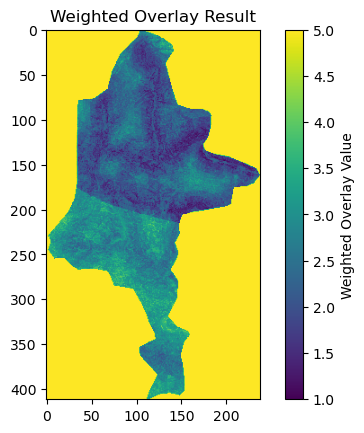

In [73]:
# Function to read raster and convert to NumPy array
def read_raster(raster_path):
    with rasterio.open(raster_path) as src:
        return src.read(1)

# Function to perform weighted overlay
def weighted_overlay(layers, weights):
    # Ensure all layers have the same shape
    shape = layers[0].shape
    
    # Perform weighted overlay
    result = np.zeros(shape, dtype=np.float32)
    for layer, weight in zip(layers, weights):
        result += layer * weight

    return result

# Assuming you have the raster paths
raster_paths = [
    'C:/Users/hanif/Desktop/BE-2020/Semester 7/SDSS/Project/Data/Slope_Final.tif',
    'C:/Users/hanif/Desktop/BE-2020/Semester 7/SDSS/Project/Data/LULC_Final.tif',
    'C:/Users/hanif/Desktop/BE-2020/Semester 7/SDSS/Project/Data/Drainage_Final.tif',
    'C:/Users/hanif/Desktop/BE-2020/Semester 7/SDSS/Project/Data/Soil_Final.tif',
    'C:/Users/hanif/Desktop/BE-2020/Semester 7/SDSS/Project/Data/Roads_Final.tif'
]

# Read raster layers into NumPy arrays
layers = [read_raster(path) for path in raster_paths]

# Assuming you have the calculated weights
weights = [0.1875, 0.1943, 0.2136, 0.2082, 0.1964]  # Replace with your actual weights

# Normalize weights to ensure they sum to 1
weights /= np.sum(weights)

# Perform weighted overlay
result_overlay = weighted_overlay(layers, weights)

# Clip the result to be in the range of 1 to 5
result_overlay = np.clip(result_overlay, 1, 5)

# Display the result using matplotlib
plt.imshow(result_overlay, cmap='viridis', vmin=1, vmax=5)  # Set vmin and vmax to match the clipped range
plt.colorbar(label='Weighted Overlay Value')
plt.title('Weighted Overlay Result')
plt.show()


In [75]:
# Save the resultant layer using metadata from the first layer
output_path = 'C:/Users/hanif/Desktop/BE-2020/Semester 7/SDSS/Project/Data/weighted_overlay_result.tif'
meta.update(dtype=rasterio.float32)

with rasterio.open(output_path, 'w', **meta) as dst:
    dst.write(result_overlay.astype(rasterio.float32), 1)
